# Introduction to analysis of camera trap images for classification
***

Camera traps are a tool used by conservationists to study and monitor a wide range of ecologies while limiting human interference. However, they also generate a vast amount of data that quickly exceeds the capacity of humans to sift through. That's where machine learning can help! Advances in computer vision can help automate tasks like species detection and identification, so that humans can spend more time learning from and protecting these ecologies.

This is a initial approach for the [Conservision Practice Area](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) challenge on DrivenData, a practice dataset where you identify animal species in a real world dataset of wildlife images from [Tai National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park) in Côte d'Ivoire. That makes it a great place to dive into the world of data science datasets and computer vision.

## 1. Set up environment
***

Next, let's import some necessary libraries of the usual suspects:

In [1]:
# Data Science libraries
import pandas as pd # data processing, CSV file I/O
from collections import Counter, OrderedDict, defaultdict

# Visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns

# System libraries
import os

## 2. Download the data
***

Download the dataset data from the [Data Download](https://www.drivendata.org/datasets/87/dataset-image-classification-wildlife-conservation/data/) page. You'll need to first register for the dataset by clicking on "Compete" and agreeing to the rules. The `dataset.zip` file contains everything you need to take part in this dataset. Unzip the archive into a location of your choice. The file structure should look like this:
```
├── benchmark.ipynb
├── submission_format.csv
├── test_features
│   ├── ZJ000000.jpg
│   ├── ZJ000001.jpg
│   └── ...
├── test_features.csv
├── train_features
│   ├── ZJ016488.jpg
│   ├── ZJ016489.jpg
│   └── ...
├── train_features.csv
└── train_labels.csv
```

## 3. Explore the data
***

In [2]:
os.chdir(r'C:\GitHub\CameraTrap-Animal-Classification')
# print(os.getcwd())

Read in the train and test CSVs first and see what they look like.

In [3]:
# dataset_path = r'C:\GitHub\CameraTrap-Animal-Classification\data\raw'
dataset_path = 'data/raw'
os.makedirs(dataset_path, exist_ok=True)

In [4]:
train_features = pd.read_csv(os.path.join(dataset_path, 'train_features.csv'), index_col="id")
test_features = pd.read_csv(os.path.join(dataset_path, 'test_features.csv'), index_col="id")
train_labels = pd.read_csv(os.path.join(dataset_path, 'train_labels.csv'), index_col="id")

In [5]:
train_features_images = [f for f in os.listdir(os.path.join(dataset_path, 'train_features')) if f.endswith('.jpg')]
test_features_images = [f for f in os.listdir(os.path.join(dataset_path, 'test_features')) if f.endswith('.jpg')]

print("Number of image files: train: {} test: {}".format(len(train_features_images), len(test_features_images)))

Number of image files: train: 16488 test: 4464


The `features` CSVs contain the image ID, filepath and site ID for each image.

In [6]:
train_features.head()

,filepath,site
id,,
ZJ000000,train_features/ZJ000000.jpg,S0120
ZJ000001,train_features/ZJ000001.jpg,S0069
ZJ000002,train_features/ZJ000002.jpg,S0009
ZJ000003,train_features/ZJ000003.jpg,S0008
ZJ000004,train_features/ZJ000004.jpg,S0036


In [7]:
test_features.head()

,filepath,site
id,,
ZJ016488,test_features/ZJ016488.jpg,S0082
ZJ016489,test_features/ZJ016489.jpg,S0040
ZJ016490,test_features/ZJ016490.jpg,S0040
ZJ016491,test_features/ZJ016491.jpg,S0041
ZJ016492,test_features/ZJ016492.jpg,S0040


The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [8]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [9]:
species_labels = sorted(train_labels.columns.unique())
print(species_labels)

['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard', 'monkey_prosimian', 'rodent']


Information in features CSVs about `site ID`

In [10]:
train_features_all_sites = sorted(train_features['site'].unique())
print(train_features_all_sites)

['S0001', 'S0002', 'S0003', 'S0004', 'S0005', 'S0006', 'S0007', 'S0008', 'S0009', 'S0010', 'S0013', 'S0014', 'S0015', 'S0016', 'S0017', 'S0018', 'S0019', 'S0020', 'S0021', 'S0022', 'S0023', 'S0024', 'S0025', 'S0026', 'S0027', 'S0028', 'S0029', 'S0030', 'S0031', 'S0032', 'S0035', 'S0036', 'S0038', 'S0042', 'S0043', 'S0044', 'S0045', 'S0046', 'S0047', 'S0049', 'S0050', 'S0051', 'S0053', 'S0054', 'S0056', 'S0059', 'S0060', 'S0061', 'S0062', 'S0063', 'S0068', 'S0069', 'S0070', 'S0071', 'S0073', 'S0074', 'S0075', 'S0076', 'S0077', 'S0078', 'S0079', 'S0080', 'S0081', 'S0083', 'S0084', 'S0085', 'S0088', 'S0089', 'S0092', 'S0093', 'S0094', 'S0095', 'S0096', 'S0097', 'S0098', 'S0101', 'S0102', 'S0104', 'S0105', 'S0106', 'S0107', 'S0108', 'S0110', 'S0112', 'S0113', 'S0115', 'S0117', 'S0119', 'S0120', 'S0121', 'S0122', 'S0123', 'S0124', 'S0125', 'S0127', 'S0129', 'S0130', 'S0131', 'S0133', 'S0134', 'S0136', 'S0137', 'S0138', 'S0139', 'S0141', 'S0143', 'S0144', 'S0146', 'S0147', 'S0148', 'S0149', 

In [11]:
test_features_all_sites = sorted(test_features['site'].unique())
print(test_features_all_sites)

['S0011', 'S0012', 'S0033', 'S0034', 'S0037', 'S0039', 'S0040', 'S0041', 'S0048', 'S0052', 'S0055', 'S0057', 'S0058', 'S0064', 'S0065', 'S0066', 'S0067', 'S0072', 'S0082', 'S0086', 'S0087', 'S0090', 'S0091', 'S0099', 'S0100', 'S0103', 'S0109', 'S0111', 'S0114', 'S0116', 'S0118', 'S0126', 'S0128', 'S0132', 'S0135', 'S0140', 'S0142', 'S0145', 'S0151', 'S0152', 'S0154', 'S0162', 'S0165', 'S0166', 'S0168', 'S0181', 'S0187', 'S0189', 'S0194', 'S0195', 'S0199']


Now let's see what some of the actual images look like. The code below iterates through a list of species and selects a single random image from each species to display, along with its image ID and label. You can try changing the `random_state` variable to display a new set of images.

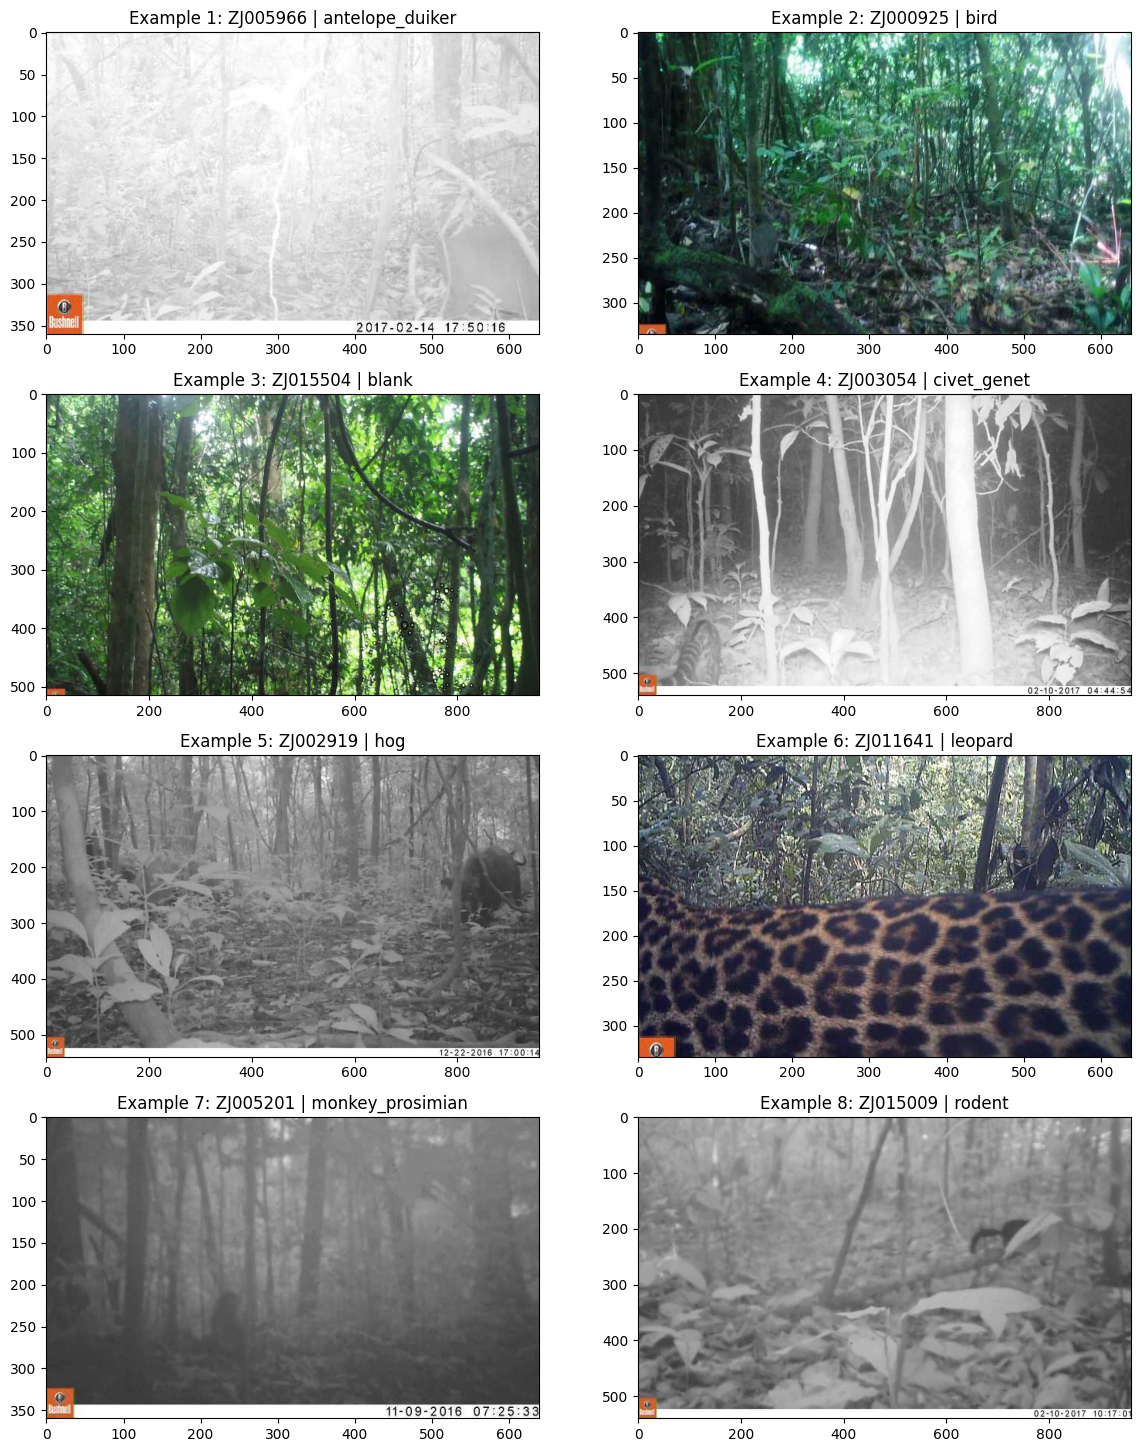

In [12]:
random_state = 73

# we'll create a grid with 8 positions, one for each label (7 species, 1 blank without animal)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 18))

# iterate through each species
for i, (species, ax) in enumerate(zip(species_labels, axes.flat)):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
        )
    # reads the filepath and returns a numpy array
    img_path = os.path.join(dataset_path, train_features.loc[img_id].filepath)
    img = mpimg.imread(img_path)
    # img = mpimg.imread(train_features.loc[img_id].filepath)

    # plot etc
    ax.imshow(img, aspect='auto')
    ax.set_title(f"Example {i+1}: {img_id} | {species}")

# plt.tight_layout()
plt.show()

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [13]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [14]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

In case you're curious, this distribution is not exactly what we find in the wild. The dataset dataset has been curated a little bit to produce a more uniform distribution than we would see in the actual data.

Distribution of the number of images for each class

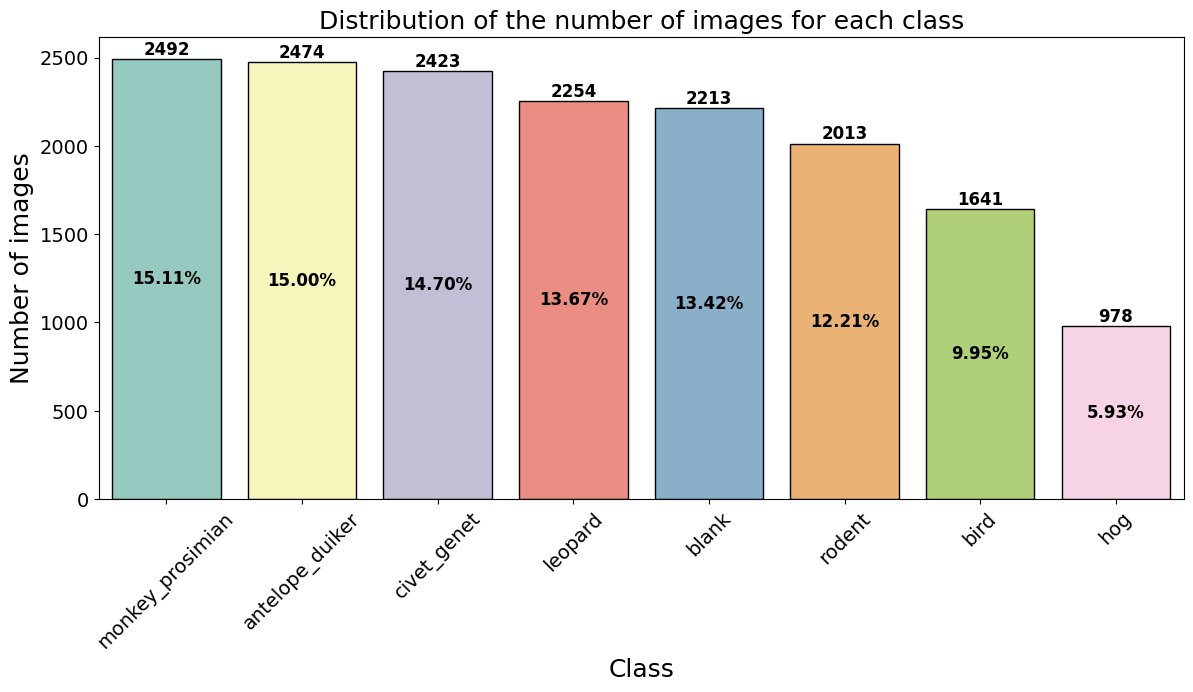

In [15]:
def plot_species_distribution(train_labels, show_percents=True, color_palette='Set3'):
    # Sum the columns of train_labels to get the count of each species
    species_counts = train_labels.sum().sort_values(ascending=False)

    # Calculate percentages
    species_percents = species_counts.divide(train_labels.shape[0]).sort_values(ascending=False)

    # Create a plot
    f, ax = plt.subplots(1, 1, figsize=(14, 6))
    total = float(train_labels.shape[0])

    # Plot the species counts
    g = sns.barplot(x=species_counts.index,
                    y=species_counts.values,
                    hue=species_counts.index,
                    palette=color_palette,
                    edgecolor="black")

    g.set_xlabel(xlabel="Class", fontsize=18)
    g.set_ylabel(ylabel="Number of images", fontsize=18)
    g.set_title("Distribution of the number of images for each class", fontsize=18)

    if show_percents:
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.0,
                    height / 2.0,
                    '{:1.2f}%'.format(100 * height / total),
                    ha="center",
                    va='center',
                    color='black',
                    fontsize=12,
                    weight='bold')

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0,
                height + 3,
                '{:.0f}'.format(height),
                ha="center",
                va='bottom',
                color='black',
                fontsize=12,
                weight='bold')

    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

plot_species_distribution(train_labels)


Dimensional analysis of images

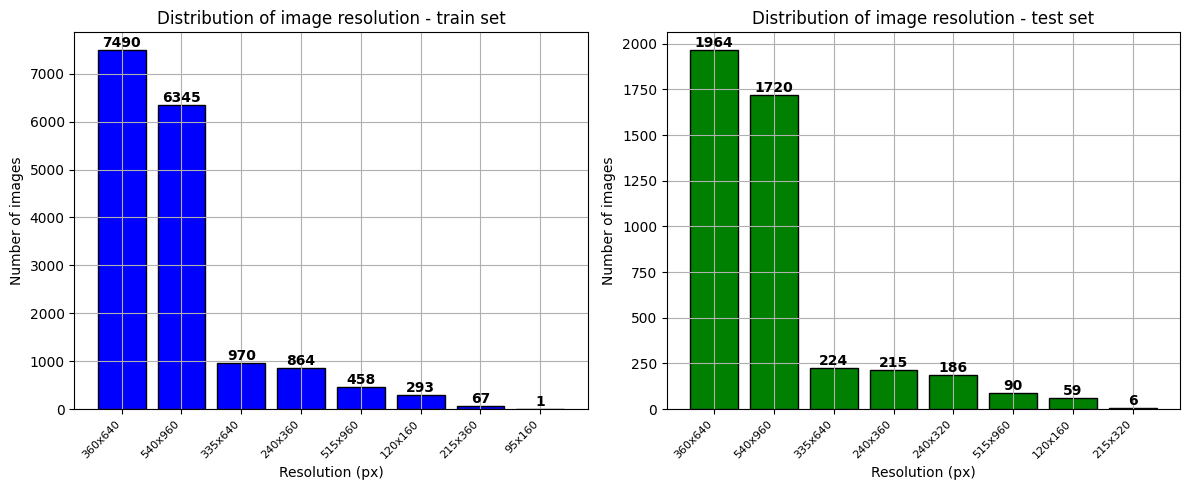

In [18]:
def get_resolution_counts(directory, max_resolutions=10):
    """Scans a directory for images and returns a Counter of their resolutions, limited to top N resolutions."""
    resolution_counts = Counter()
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(root, filename)
                try:
                    with Image.open(file_path) as img:
                        resolution = (img.height, img.width)
                        resolution_counts[resolution] += 1
                except Exception as e:
                    print(f"Could not process image {filename}: {e}")
    return dict(resolution_counts.most_common(max_resolutions))

def plot_histogram(ax, resolution_counts, title, color):
    """Plots a histogram of image resolutions on a given Axes object."""
    if resolution_counts:
        sorted_resolutions = sorted(resolution_counts.items(), key=lambda x: x[1], reverse=True)
        resolutions, counts = zip(*sorted_resolutions)
        resolution_labels = [f"{h}x{w}" for h, w in resolutions]
        bars = ax.bar(resolution_labels, counts, color=color, edgecolor='black')

        # Add labels on top of the bars
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    str(count), ha='center', va='bottom', fontsize=10, weight='bold')

        ax.set_title(title)
        ax.set_xlabel('Resolution (px)')
        ax.set_ylabel('Number of images')
        ax.set_xticks(range(len(resolution_labels)))
        ax.set_xticklabels(resolution_labels, rotation=45, ha='right', fontsize=8)
        ax.grid(True)
    else:
        ax.text(0.5, 0.5, 'No images found', ha='center', va='center')
        ax.set_title(title)

def check_image_resolutions_and_plot_histogram(directory_train, directory_test, max_resolutions=10):
    """Scans the directories for images, checks their resolutions, and plots histograms in a 1x2 grid."""
    train_resolution_counts = get_resolution_counts(directory_train, max_resolutions)
    test_resolution_counts = get_resolution_counts(directory_test, max_resolutions)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    plot_histogram(axes[0], train_resolution_counts, 'Distribution of image resolution - train set', 'blue')
    plot_histogram(axes[1], test_resolution_counts, 'Distribution of image resolution - test set', 'green')

    plt.tight_layout()
    plt.show()

# Directories
directory_train = 'data/raw/train_features'
directory_test = 'data/raw/test_features'

check_image_resolutions_and_plot_histogram(directory_train, directory_test, max_resolutions=20)

Distribution of images by class and resolution for train_features

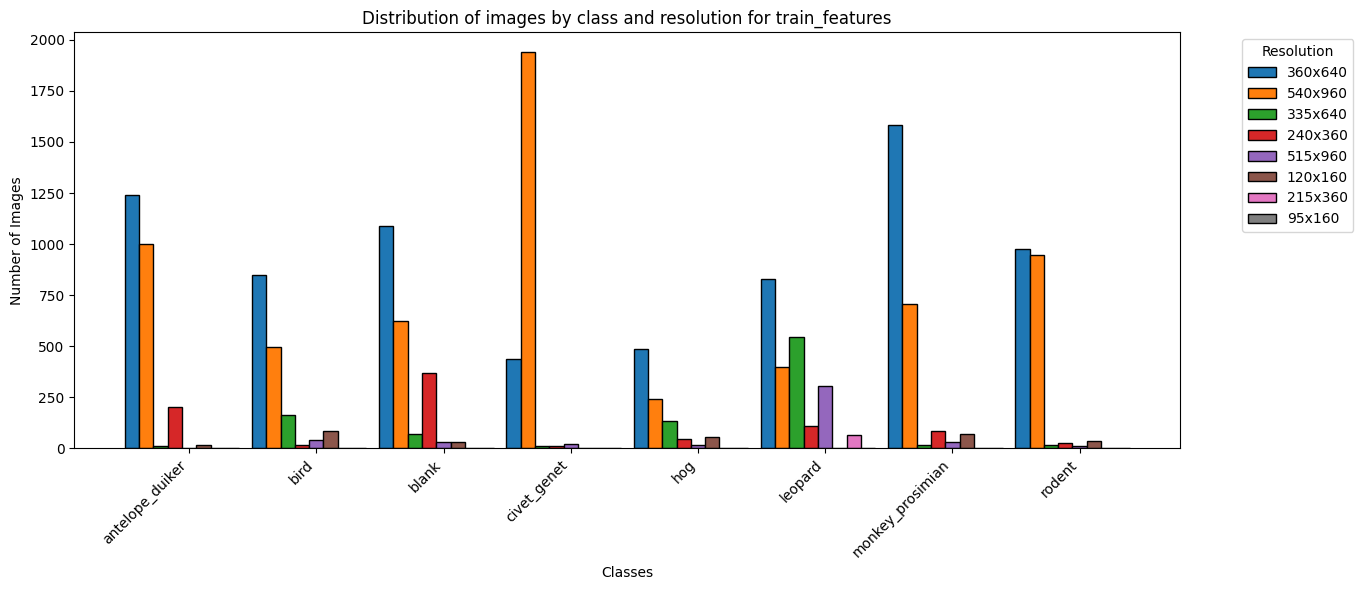

In [19]:
# Extract image resolutions for each image in the training set
def get_image_resolutions(train_features, directory_train):
    resolutions = {}
    for img_id, row in train_features.iterrows():
        filepath = row['filepath']
        file_path = os.path.join(directory_train, os.path.basename(filepath))
        try:
            with Image.open(file_path) as img:
                resolution = f"{img.height}x{img.width}"
                resolutions[img_id] = resolution
        except Exception as e:
            print(f"Could not process image {filepath}: {e}")
            resolutions[img_id] = "Unknown"
    return resolutions

# Directory path for training images
directory_train = 'data/raw/train_features'

# Fetch image resolutions
train_features['resolution'] = get_image_resolutions(train_features, directory_train)

# Join the image resolutions with class labels
train_data = train_labels.join(train_features['resolution'])

# Limit the number of resolutions to the top 10 most common
top_resolutions = train_data['resolution'].value_counts().nlargest(10).index.tolist()

# Remove any resolution that is not in the top 10
train_data['resolution_grouped'] = train_data['resolution'].apply(lambda x: x if x in top_resolutions else None)

# Filter out None values (those that were not in the top 10 resolutions)
train_data = train_data[train_data['resolution_grouped'].notnull()]

# Count the number of images for each resolution within each class
class_resolution_counts = defaultdict(lambda: defaultdict(int))

for class_label in species_labels:
    class_data = train_data[train_data[class_label] == 1]
    resolution_counts = class_data['resolution_grouped'].value_counts()
    for resolution, count in resolution_counts.items():
        class_resolution_counts[class_label][resolution] = count

# Convert the results to a DataFrame
resolution_class_df = pd.DataFrame(class_resolution_counts).fillna(0).astype(int).T

# Ensure all top resolution columns are present
for res in top_resolutions:
    if res not in resolution_class_df.columns:
        resolution_class_df[res] = 0

# Create a grouped vertical bar plot with bordered bars
fig, ax = plt.subplots(figsize=(12, 6))

# Number of classes (rows in the dataframe)
num_classes = len(resolution_class_df)

# Increase bar width and adjust position spacing to evenly distribute bars within each class
total_bar_width = 0.9  # Total width allocated to each class group
bar_width = total_bar_width / len(top_resolutions)  # Bar width per resolution
x_pos = range(num_classes)

# Plot each group of bars for different resolutions
for i, resolution in enumerate(top_resolutions):
    ax.bar(
        [pos + i * bar_width for pos in x_pos],
        resolution_class_df[resolution],
        width=bar_width,
        label=resolution,
        edgecolor='black'
    )

plt.title('Distribution of images by class and resolution for train_features')
plt.xlabel('Classes')
plt.ylabel('Number of Images')

# Adjust X-axis to show class labels in the middle of grouped bars
ax.set_xticks([pos + bar_width * (len(top_resolutions) / 2) for pos in x_pos])
ax.set_xticklabels(resolution_class_df.index, rotation=45, ha='right')

plt.tight_layout()

plt.legend(title='Resolution', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [35]:
# # Convert the DataFrame (resolution_class_df) to the desired Excel format
# # Add a new column 'species' containing the class names
# resolution_class_df['species'] = resolution_class_df.index

# # Reorder columns so 'species' comes first
# columns_order = ['species'] + top_resolutions
# resolution_class_df = resolution_class_df[columns_order]

# output_path = 'class_resolution_train_features.csv'
# resolution_class_df.to_csv(output_path, index=False)

# print(f"Data successfully exported to {output_path}")

Distribution of images taken at different locations in train_features

                           filepath   site
count                         16488  16488
unique                        16488    148
top     train_features/ZJ001645.jpg  S0060
freq                              1   1132
Number of unique sites: 148
OrderedDict([('001', 85), ('002', 171), ('003', 58), ('004', 109), ('005', 81), ('006', 16), ('007', 9), ('008', 541), ('009', 664), ('010', 73), ('013', 89), ('014', 313), ('015', 15), ('016', 59), ('017', 19), ('018', 75), ('019', 43), ('020', 245), ('021', 164), ('022', 303), ('023', 229), ('024', 56), ('025', 42), ('026', 104), ('027', 75), ('028', 29), ('029', 141), ('030', 197), ('031', 216), ('032', 48), ('035', 30), ('036', 456), ('038', 429), ('042', 38), ('043', 444), ('044', 25), ('045', 51), ('046', 10), ('047', 79), ('049', 191), ('050', 16), ('051', 152), ('053', 184), ('054', 28), ('056', 48), ('059', 438), ('060', 1132), ('061', 115), ('062', 380), ('063', 557), ('068', 30), ('069', 217), ('070', 185), ('071', 306), ('073', 114), (

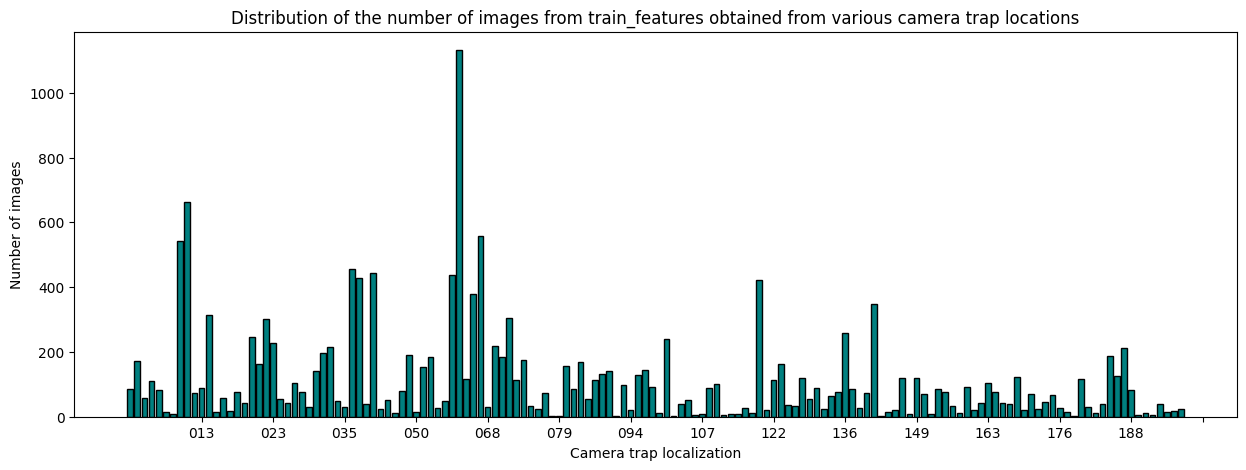

In [20]:
# Load the dataset
train_features = pd.read_csv("data/raw/train_features.csv", index_col="id")

# Sort the DataFrame by the 'site' column in descending order
sorted_sites = train_features.sort_values(['site'], ascending=False)

# Display summary statistics of the sorted DataFrame
print(sorted_sites.describe())

# Get the unique site names and count the number of unique sites
unique_sites = sorted_sites["site"].unique()
number_of_sites = unique_sites.shape[0]
print(f"Number of unique sites: {number_of_sites}")

# Create a list to hold the site endings
site_endings = []

# Extract the site endings from the DataFrame
for row in train_features.itertuples(index=False):
    for value in row:
        # Ensure the value is a string before attempting to slice
        if isinstance(value, str):
            ending = value[-3:]
            if ending != "jpg":  # Exclude 'jpg' endings
                site_endings.append(ending)

# Count the occurrences of each site ending
site_counts = dict(Counter(site_endings))

# Order the dictionary by keys
ordered_site_counts = OrderedDict(sorted(site_counts.items()))
print(ordered_site_counts)

# Plot the distribution
fig = plt.figure(figsize=(15, 5))
plt.bar(ordered_site_counts.keys(), ordered_site_counts.values(), color='teal', edgecolor='black')
plt.xticks([10,20,30,40,50,60,70,80,90,100,110,120,130,140,150])
plt.xlabel("Camera trap localization")
plt.ylabel("Number of images")
plt.title("Distribution of the number of images from train_features obtained from various camera trap locations")
plt.show()

Distribution of images taken at different locations in test_features

                          filepath   site
count                         4464   4464
unique                        4464     51
top     test_features/ZJ018221.jpg  S0040
freq                             1    495
OrderedDict([('011', 54), ('012', 76), ('033', 180), ('034', 24), ('037', 130), ('039', 49), ('040', 495), ('041', 153), ('048', 10), ('052', 39), ('055', 51), ('057', 21), ('058', 17), ('064', 159), ('065', 87), ('066', 64), ('067', 111), ('072', 312), ('082', 131), ('086', 225), ('087', 43), ('090', 1), ('091', 65), ('099', 4), ('100', 207), ('103', 9), ('109', 9), ('111', 109), ('114', 169), ('116', 251), ('118', 36), ('126', 80), ('128', 258), ('132', 29), ('135', 17), ('140', 10), ('142', 85), ('145', 23), ('151', 51), ('152', 6), ('154', 6), ('162', 359), ('165', 24), ('166', 29), ('168', 14), ('181', 4), ('187', 4), ('189', 67), ('194', 37), ('195', 2), ('199', 68)])


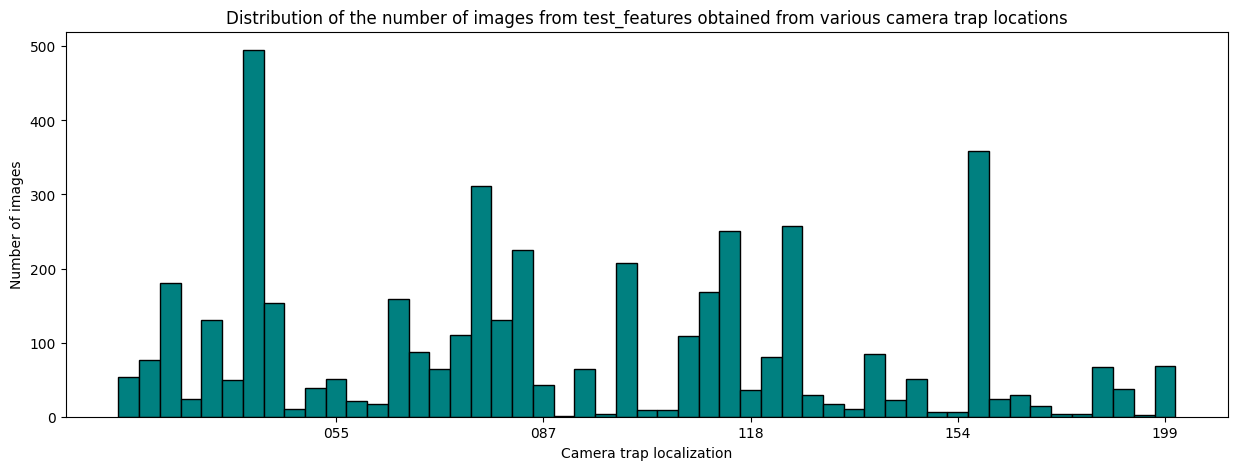

In [21]:
test_features = pd.read_csv("data/raw/test_features.csv", index_col="id")

# Sort the DataFrame by the 'site' column in descending order
sorted_sites = test_features.sort_values(['site'], ascending=False)

# Display summary statistics of the sorted DataFrame
print(sorted_sites.describe())

# Get the unique site names and count the number of unique sites
unique_sites = sorted_sites["site"].unique()
number_of_sites = unique_sites.shape[0]

# Create a list to hold the site endings
site_endings = []

# Extract the site endings from the DataFrame
for row in test_features.itertuples(index=False):
    for keys,values in enumerate(row):
        ending = values[-3:]
        if ending == "jpg":
            pass
        else:
            site_endings.append(ending)

# Count the occurrences of each site ending
site_counts = dict(Counter(site_endings))

# Order the dictionary by keys
ordered_site_counts = OrderedDict(sorted(site_counts.items()))
print(ordered_site_counts)

fig = plt.figure(figsize = (15,5))
plt.bar(ordered_site_counts.keys(), ordered_site_counts.values(), 1, color = 'teal', edgecolor='black')
plt.xticks([10,20,30,40,50])
plt.xlabel("Camera trap localization")
plt.ylabel("Number of images")
plt.title("Distribution of the number of images from test_features obtained from various camera trap locations")
plt.show()